In [1]:
!pip install scikit-learn

     |████████████████████████████████| 9.7 MB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 68.9 MB/s eta 0:00:01


In [17]:
import json
import os
import shutil
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

from sklearn.model_selection import KFold

# json file 만들기

In [31]:
def kfold(file_path, n_splits, random_state):
    with open(file_path, 'r') as f:
        dataset = json.loads(f.read())

    imgs = dataset['images']
    annos = dataset['annotations']

    ids = list(set([x['image_id'] for x in dataset['annotations']]))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    # a = kf.get_n_splits(ids)
    # print(a)
    for i, (train_index, val_index) in enumerate(kf.split(ids)):
        info = dataset['info']
        licenses = dataset['licenses']
        train_images = []
        val_images = []
        categories = dataset['categories']
        train_annotations = []
        val_annotations = []

        for j in range(len(imgs)):
            if imgs[j]['id'] in train_index:
                train_images.append(imgs[j])
            else:
                val_images.append(imgs[j])
        
        for j in range(len(annos)):
            if annos[j]['image_id'] in train_index:
                train_annotations.append(annos[j])
            else:
                val_annotations.append(annos[j])
        
        train = dict()
        train['info'] = info
        train['licenses'] = licenses
        train['images'] = train_images
        train['categories'] = categories
        train['annotations'] = train_annotations
        val = dict()
        val['info'] = info
        val['licenses'] = licenses
        val['images'] = val_images
        val['categories'] = categories
        val['annotations'] = val_annotations
        
        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}')

        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}')

        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations')
        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations/train'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations/train')
        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations/val'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/annotations/val')

        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images')
        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images/train'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images/train')
        if not os.path.isdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images/val'):
            os.mkdir(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/fold{i}/images/val')

        with open(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/train_fold{i}.json', 'w') as f:
            json.dump(train, f, indent=4)
        with open(f'/opt/ml/input/data/{n_splits}folds_seed{random_state}/val_fold{i}.json', 'w') as f:
            json.dump(val, f, indent=4)



In [32]:
file_path = '/opt/ml/input/data/train_all.json'
n_splits = 5
random_state = 42
kfold(file_path, n_splits, random_state)

# image data, json 옮기기

In [33]:
path = '/opt/ml/input/data/5folds_seed42/'
for i in range(n_splits):
    fold = f'fold{i}'

    shutil.copytree('/opt/ml/input/data/batch_01_vt', path+fold + '/data/batch_01_vt')
    shutil.copytree('/opt/ml/input/data/batch_02_vt', path+fold + '/data/batch_02_vt')
    shutil.copytree('/opt/ml/input/data/batch_03', path+fold + '/data/batch_03')
    
    with open(f'/opt/ml/input/data/5folds_seed42/train_fold{i}.json') as f:
        train = json.load(f)
    with open(f'/opt/ml/input/data/5folds_seed42/val_fold{i}.json') as f:
        val = json.load(f)

    trainset, valset = [], []
    for x in train['images']:
        file_name = x['file_name']
        trainset.append(file_name)
    for x in val['images']:
        file_name = x['file_name']
        valset.append(file_name)
    
    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_01_vt/'
    for x in os.listdir(dir_path):
        if 'batch_01_vt/' + x in trainset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/train'+'/train_1' + x)
    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_02_vt/'
    for x in os.listdir(dir_path):
        if 'batch_02_vt/' + x in trainset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/train'+'/train_2' + x)
    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_03/'
    for x in os.listdir(dir_path):
        if 'batch_03/' + x in trainset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/train'+'/train_3' + x)

    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_01_vt/'
    for x in os.listdir(dir_path):
        if 'batch_01_vt/' + x in valset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/val'+'/val_1' + x)
    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_02_vt/'
    for x in os.listdir(dir_path):
        if 'batch_02_vt/' + x in valset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/val'+'/val_2' + x)
    dir_path = f'/opt/ml/input/data/5folds_seed42/fold{i}/data/batch_03/'
    for x in os.listdir(dir_path):
        if 'batch_03/' + x in valset:
            os.rename(dir_path+x, f'/opt/ml/input/data/5folds_seed42/fold{i}/images/val'+'/val_3' + x)
    
    shutil.rmtree(f'/opt/ml/input/data/5folds_seed42/fold{i}/data')

    for x in train['images']:
        if 'batch_01' in x['file_name']:
            x['file_name'] = 'train/train_1' + x['file_name'][-8:]
        elif 'batch_02' in x['file_name']:
            x['file_name'] = 'train/train_2' + x['file_name'][-8:]
        else:
            x['file_name'] = 'train/train_3' + x['file_name'][-8:]
    for x in val['images']:
        if 'batch_01' in x['file_name']:
            x['file_name'] = 'val/val_1' + x['file_name'][-8:]
        elif 'batch_02' in x['file_name']:
            x['file_name'] = 'val/val_2' + x['file_name'][-8:]
        else:
            x['file_name'] = 'val/val_3' + x['file_name'][-8:]
    
    with open(f'/opt/ml/input/data/5folds_seed42/fold{i}/annotations/train_fold{i}.json','w') as f:
        json.dump(train, f, ensure_ascii=False, indent=4)
    with open(f'/opt/ml/input/data/5folds_seed42/fold{i}/annotations/val_fold{i}.json','w') as f:
        json.dump(val, f, ensure_ascii=False, indent=4)
    
    os.remove(f'/opt/ml/input/data/5folds_seed42/train_fold{i}.json')
    os.remove(f'/opt/ml/input/data/5folds_seed42/val_fold{i}.json')

# mask image 만들기

In [34]:
class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [35]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [108]:
fold_index = 4 # 수정 필요
dataset_path  = f'/opt/ml/input/data/5folds_seed42/fold{fold_index}/images'
anns_file_path = f'/opt/ml/input/data/5folds_seed42/fold{fold_index}/annotations/val_fold{fold_index}.json' # 파일명 수정 필요(train, val)

In [109]:
%matplotlib inline

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 5024
Number of images: 655


/tmp/ipykernel_5964/2026908457.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  df = df.sort_values('Number of annotations', 0, False)


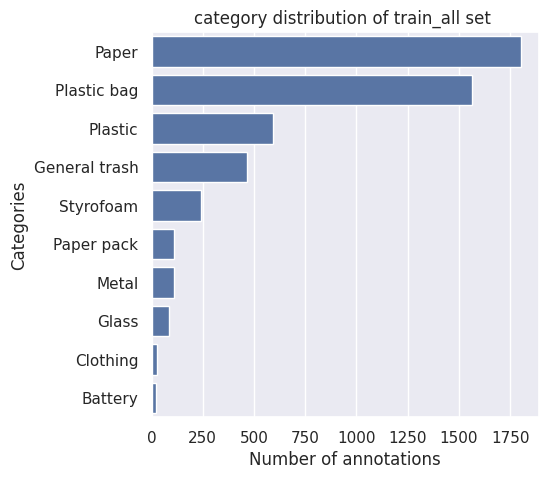

In [110]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [111]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [112]:
category_names = list(sorted_df.Categories)

In [113]:
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [114]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)
sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

/tmp/ipykernel_5964/2218006110.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  df = df.sort_values('Number of annotations', 0, False)


In [115]:
for index in coco.getImgIds():
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    # print(image_infos)
    images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
    images /= 255.0

    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    # masks : size가 (height x width)인 2D
    # 각각의 pixel 값에는 "category id" 할당
    # Background = 0
    masks = np.zeros((image_infos["height"], image_infos["width"]))
    # General trash = 1, ... , Cigarette = 10
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)

    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)

    cv2.imwrite(f'/opt/ml/input/data/5folds_seed42/fold{fold_index}/annotations/' + image_infos['file_name'].split('.')[0] + '.png', masks)